In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

# from model import MSResNet

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
shot_types = 9
other_metrics = 1
total_metics = 10

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
path = "data/"

In [80]:
np.random.randint(10)

9

In [81]:
X_data = []
y_data = [] 
for i in range(100):
    for csv in glob.glob(path + "*.csv"):
        x = pd.read_csv(csv).drop(columns="Unnamed: 0")
        y = np.zeros(total_metics)
        y[x["shot_type"][0]] = 1
        y[-1] = x["distance"][0] + np.random.randint(10)
        x_values = x.values[:, :-2].T + np.random.random(x.values[:, :-2].T.shape)
        X_data.append(x_values)
        y_data.append(y)
        
X_data = np.array(X_data)
y_data = np.array(y_data)

In [82]:
class SwingDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super().__init__()
        self.X_data = torch.Tensor(X_data)
        self.y_data = torch.Tensor(y_data)
        
    def __len__(self):
        return self.X_data.shape[0]
    
    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

In [83]:
n = X_data.shape[0]

In [87]:
# GENERATE DATA SPLITS
train = 0.9
val = 0.05
test = 0.05

X_train = X_data[:int(n*train),:,:] 
y_train = y_data[:int(n*train),:]

X_val = X_data[int(n*train):int(n*(val+train)),:,:]
y_val = y_data[int(n*train):int(n*(val+train)),:]

X_test = X_data[-int(n*val):,:,:]
y_test = y_data[-int(n*val):,:]

# /GENERATE DATA SPLITS

In [88]:
def norm(x, m, s):
    return (x - m) / s

In [94]:
y_train[:,-1].shape

(90,)

In [95]:
# NORMALIZE
# TODO: save these mean/std cause we gon need it for running in inference mode
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

y_distance_mean = y_train[:, -1].mean()
y_distance_std = y_train[:, -1].std()

In [106]:
X_train_norm = norm(X_train, train_mean, train_std)
X_val_norm = norm(X_val, train_mean, train_std)

y_train_norm = y_train.copy()
y_val_norm = y_val.copy()
y_train_norm[:, -1] -= y_distance_mean
y_train_norm[:, -1] /= y_distance_std
y_val_norm[:, -1] -= y_distance_mean
y_val_norm[:, -1] /= y_distance_std

In [195]:
train_set = SwingDataset(X_train_norm, y_train_norm)
val_set = SwingDataset(X_val_norm, y_val_norm)
# test_set = DiskDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=4, drop_last=False)

In [223]:
class BadModel(nn.Module):

    def __init__(self, num_conv_outer, num_conv_inner, ksize, 
                 num_hidden=1, num_unit=100, nchannel_base=6, num_class=10):
        super(BadModel, self).__init__()
        
        # 6 dims from ax,ay,az,gx,gy,gz
        indim = 6
        
        # TODO: Set this to whatever the truncated input length is
        # or better yet, determine it dynamically 
        cur_w = 2285
        
        self.num_hidden = num_hidden
        self.num_conv_outer = num_conv_outer
        self.num_conv_inner = num_conv_inner
        
        outdim = None
        for _i in range(num_conv_outer):
            outdim = nchannel_base * 2 ** _i
            for _j in range(num_conv_inner):
                setattr(self, f"conv_conv1d_{_i}_{_j}", nn.Conv1d(indim, outdim, ksize))
                setattr(self, f"conv_relu_{_i}_{_j}", nn.ReLU())
                cur_w = (cur_w - ksize) + 1
                indim = outdim

            setattr(self, f"conv_pool_{_i}", nn.MaxPool1d(2, 2))
            cur_w = (cur_w - 2) // 2 + 1

        indim = outdim * cur_w
        for _i in range(num_hidden):
            outdim = num_unit
            setattr(self, f"fc_linear_{_i}", nn.Linear(indim, outdim))
            setattr(self, f"fc_relu_{_i}", nn.ReLU())
            indim = outdim
            
        self.output = nn.Linear(indim, num_class)
        self.softmax = nn.Softmax(dim=1)

#         print(self)
        
    def forward(self, x):
        for _i in range(self.num_conv_outer):
            for _j in range(self.num_conv_inner):
                x = getattr(self, f"conv_conv1d_{_i}_{_j}")(x)
                x = getattr(self, f"conv_relu_{_i}_{_j}")(x)
            x = getattr(self, f"conv_pool_{_i}")(x)

        # Flatten
        x = x.view(x.shape[0], -1)
        
        # Apply the fully connected layers
        for _i in range(self.num_hidden):
            x = getattr(self, "fc_linear_{}".format(_i))(x)
            x = getattr(self, "fc_relu_{}".format(_i))(x)
        x = self.output(x)

        # softmax on the swing type classes
        swing_type = self.softmax(x[:,:-1])
        
        # concatenate back with the distance regression
        x = torch.cat([swing_type, x[:,-1:]], axis=1)
        
        return x

In [224]:
bestmodel_file = os.path.join("weights", "best_model.pth")

model = BadModel(5, 1, 3).to(device)
# model = MSResNet(input_channel=6, num_classes=10)

swing_type_loss = nn.BCELoss()
distance_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
va_losses = []
num_epochs = 10
iter_idx = -1
best_va_loss = 9999 
val_interval = 50
report_interval = 10

In [232]:
loss_history = []
epochs = 10
for e in range(epochs):
    prefix = "Epoch {:3d}: ".format(e)
    for data in tqdm(train_loader, desc=prefix):
#     for data in train_loader:
        iter_idx += 1
        X_train, y = data
        X_train = X_train.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_train.float())
        
        swing_loss = swing_type_loss(outputs[:, :-1], y[:, :-1])
        dist_loss =  distance_loss(outputs[:, -1:], y[:, -1:])
        loss = swing_loss + dist_loss
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if iter_idx % val_interval == 0:
            va_loss = []
            model = model.eval()
            for data in val_loader:
                X_va, y_va = data
                X_va = X_va.to(device)
                y_va = y_va.to(device)
                with torch.no_grad():
                    outputs_va = model(X_va.float())               
                    swing_loss = swing_type_loss(outputs_va[:, :-1], y_va[:, :-1])
                    dist_loss =  distance_loss(outputs_va[:, -1:], y_va[:, -1:])
                    loss = swing_loss + dist_loss
                    va_loss += [loss.cpu().numpy()]
                    
            model = model.train()
            va_loss = np.mean(va_loss)
            va_losses.append(va_loss)
            
            if va_loss < best_va_loss:
                best_va_loss = va_loss
                torch.save({
                    "iter_idx": iter_idx,
                    "best_va_loss": best_va_loss,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                }, bestmodel_file)

Epoch   9: 100%|██████████| 23/23 [00:00<00:00, 207.87it/s]


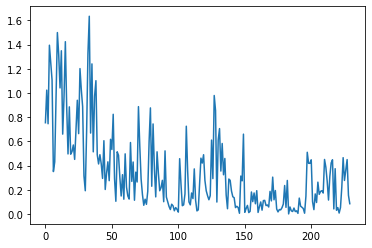

In [233]:
plt.plot(loss_history)

In [234]:
shot_types = ["Pull-hook", "Hook", "Pull", "Fade", "Straight", "Draw", "Push", "Slice" , "Push-slice"]

In [235]:
def print_preds(predicitons, std, mean):
    for pred in predicitons:
        distance = pred[-1] * std + mean
        argmax = torch.argmax(outputs[0][:-1])
        shot_type = shot_types[argmax]
        print(f"Shot type: {shot_type}, distance: {round(distance.item())}yds")

In [236]:
print_preds(outputs, y_distance_std, y_distance_mean)

Shot type: Straight, distance: 156yds
Shot type: Straight, distance: 156yds


In [237]:
outputs.shape

torch.Size([2, 10])

In [ ]:
# TODO: create a test loop or another test notebook